### Lectura de la imagen e inicializacion de variables

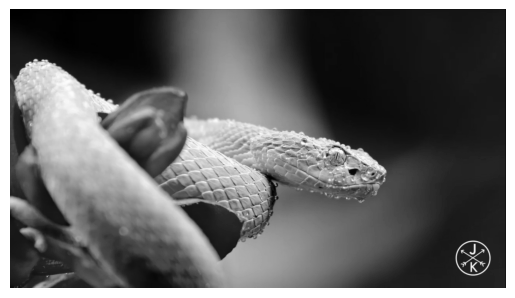

In [48]:
#Lectura de la imagen e inicializacion de variables
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from scipy import signal
from skimage.color import rgb2gray


qpsk = np.array([1+1j, -1+1j, 1-1j, -1-1j]) / np.sqrt(2)

qam16 = np.array([-3-3j, -3-1j, -3+3j, -3+1j,  
                          -1-3j, -1-1j, -1+3j, -1+1j,  
                           3-3j,  3-1j,  3+3j,  3+1j,  
                           1-3j,  1-1j,  1+3j,  1+1j]) / np.sqrt(10)

qam64 = np.array([-7-7j, -7-5j, -7-3j, -7-1j, -7+7j, -7+5j, -7+3j, -7+1j,
                          -5-7j, -5-5j, -5-3j, -5-1j, -5+7j, -5+5j, -5+3j, -5+1j,
                          -3-7j, -3-5j, -3-3j, -3-1j, -3+7j, -3+5j, -3+3j, -3+1j,
                          -1-7j, -1-5j, -1-3j, -1-1j, -1+7j, -1+5j, -1+3j, -1+1j,
                           7-7j,  7-5j,  7-3j,  7-1j,  7+7j,  7+5j,  7+3j,  7+1j,
                           5-7j,  5-5j,  5-3j,  5-1j,  5+7j,  5+5j,  5+3j,  5+1j,
                           3-7j,  3-5j,  3-3j,  3-1j,  3+7j,  3+5j,  3+3j,  3+1j,
                           1-7j,  1-5j,  1-3j,  1-1j,  1+7j,  1+5j,  1+3j,  1+1j]) / np.sqrt(42)

#Parámetros 
Modulacion = '16-QAM' #Modulacion
BW = 10 #Ancho de banda en MHz
Referencia = 4+4j
AntenasTx = 4
AntenasRx = 4
# Leer la imagen

imagena = mpimg.imread("Frame1.jpg")
imagenb = mpimg.imread("Frame3.jpg")
imagenc = mpimg.imread("captura.jpg")
imagend = mpimg.imread("captura2.jpg")
imagen = rgb2gray(imagena)*255
imagen2 = rgb2gray(imagenb)*255
imagen3 = rgb2gray(imagenc)*255
imagen4 = rgb2gray(imagend)*255
datos_array = np.array(imagen, dtype=np.uint8)
datos_array2 = np.array(imagen2, dtype=np.uint8)
datos_array3 = np.array(imagen3, dtype=np.uint8)
datos_array4 = np.array(imagen4, dtype=np.uint8)
datos1 = np.unpackbits(datos_array.flatten())
datos2 = np.unpackbits(datos_array2.flatten())
datos3 = np.unpackbits(datos_array3.flatten())
datos4 = np.unpackbits(datos_array4.flatten())

# Mostrar el número total de bits
# Mostrar la imagen original
plt.imshow(datos_array,cmap='gray')
plt.axis('off')
plt.show()

### Modulacion QPSK, 16-QAM, 64-QAM

In [49]:
#Modulacion QPSK, 16-QAM, 64-QAM
def generarSimbolos(datos, modulacion):
    longitud = len(datos)
    
    if modulacion == 'QPSK':
        # 2 bits por símbolo
        datos = np.array(datos).reshape(-1, 2)
        indices = datos.dot(1 << np.arange(2)[::-1])  # Mapea los bits a índices
        simbolos = qpsk[indices]

    elif modulacion == '16-QAM':
        # 4 bits por símbolo
        datos = np.array(datos).reshape(-1, 4)
        indices = datos.dot(1 << np.arange(4)[::-1])  # Mapea los bits a índices
        simbolos = qam16[indices]

    elif modulacion == '64-QAM':
        # 6 bits por símbolo
        datos = np.array(datos).reshape(-1, 6)
        indices = datos.dot(1 << np.arange(6)[::-1])  # Mapea los bits a índices
        simbolos = qam64[indices]

    else: 
        raise Exception('Solo de QPSK a 64QAM.')
    
    return simbolos
datos = [datos1,datos2,datos3,datos4]
nBloques = math.ceil(BW/0.18)
nSubportadoras = nBloques * 12
modulado = []
for antena in range(AntenasTx):
    modulado2 = generarSimbolos(datos[antena],Modulacion)
    for i in range(6,nSubportadoras,12):
        modulado2 = np.insert(modulado2, i, Referencia)
    modulado.append(modulado2)

nSimbolos = len(modulado[0])
nSimbolosOFDM = math.ceil(nSimbolos/nSubportadoras)
print('Número de bloques de recursos:',nBloques)
print('Número de subportadoras:',nSubportadoras)
print('Número de símbolos a enviar:',nSimbolos)
print('Número de símbolos OFDM:',nSimbolosOFDM)

Número de bloques de recursos: 56
Número de subportadoras: 672
Número de símbolos a enviar: 2098232
Número de símbolos OFDM: 3123


### Modulacion OFDM

In [50]:
#Modulacion OFDM
N = 2**math.ceil(math.log2(nSubportadoras))
print(N)
datosOFDM = []
for antena in range(AntenasTx):
    datosOFDM2 = np.zeros(nSimbolosOFDM * N, np.complex64)
    j = 0  # Índice para los datos de entrada
    k = 0  # Índice para los datos OFDM
    for i in range(nSimbolosOFDM):
        scArray = np.zeros(N, np.complex64)
        if i == (nSimbolosOFDM-1):
            longitud=len(modulado[antena][j:j+nSubportadoras])
            if longitud < nSubportadoras:
                scArray[0:nSubportadoras] = np.concatenate((modulado[antena][j:j+nSubportadoras],np.zeros(nSubportadoras-longitud)))
            else:
                scArray[0:nSubportadoras] = modulado[antena][j:j+nSubportadoras]
        else:
            scArray[0:nSubportadoras] = modulado[antena][j:j+nSubportadoras]
        # Realizar la modulación IFFT
        datosOFDM2[k:k + N] = np.fft.ifft(scArray, N)  # Aplicar IFFT para convertir los datos al dominio del tiempo
        # Incrementar los índices
        j = j + nSubportadoras  # Incrementar el índice para los datos de entrada
        k = k + N  # Incrementar el índice para los datos OFDM
    datosOFDM.append(datosOFDM2)

print(len(datosOFDM[0]))
print(len(datosOFDM))
print(len(datosOFDM))

1024
3197952
4
4


### Prefijo ciclico

In [51]:
# Define la función para agregar el prefijo cíclico (CP)
def anadirPrefijo(simboloOfdm, N, longitudCP):
    # Extraer el CP (las últimas longitudCP muestras del símbolo OFDM)
    cp = simboloOfdm[N - longitudCP:N:1]
    
    # Concatenar el CP y el símbolo OFDM
    simboloOfdm_cp = np.concatenate((cp, simboloOfdm))
    
    return simboloOfdm_cp



longitudCP = math.ceil((N/66.666666)*4.7)
#longitudCP = 0

# Agregar el CP a cada uno de los símbolos OFDM
ofdmConCP = []
for antena in range(AntenasTx):
    ofdmConCP2 = np.zeros(nSimbolosOFDM * (N + longitudCP), np.complex64)  # Inicializar un array para los datos OFDM con CP
    j = 0
    k = 0
    for i in range(nSimbolosOFDM):
        # Llamar a la función anadirPrefijo para agregar el CP al símbolo OFDM y almacenarlo en el array ofdmConCP
        ofdmConCP2[k:(k + N + longitudCP)] = anadirPrefijo(datosOFDM[antena][j:j + N], N, longitudCP)
        
        # Incrementar los índices para la siguiente iteración
        j = j + N
        k = k + N + longitudCP

    ofdmConCP.append(ofdmConCP2)


### Efectos del canal

In [52]:
#Efectos del canal
# Parámetros del canal de multicamino
def awgn(senal,SNR):
    # Measure signal power 
    potenciaSenal = np.mean(abs(senal)**2)

    # Calculate noise power 
    potenciaRuido = potenciaSenal/(10 **(SNR/10))
    
    # Generate complex noise 
    noise = np.sqrt(potenciaRuido/2)*(np.random.randn(len(senal)) + np.random.randn(len(senal))*1j)
    
    # Add signal and noise 
    senalRuidosa = senal + noise 
    
    return senalRuidosa 
Power = 11

h = []
c = []
c_antena = []
Senal_Rx = []
Senal_Rxmp = []

nCaminos = 5
SNR = 30 # Desired SNR (dB) 
for antenarx in range(AntenasRx):
    Senal_antena =  np.zeros(len(ofdmConCP[0]), np.complex64)
    Senal_antenamp =  np.zeros(len(ofdmConCP[1]), np.complex64)
    h_antena = []
    for antenatx in range(AntenasTx):
        h1 = np.random.randn(nCaminos) + np.random.randn(nCaminos)*1j
        # Aplicar filtro del canal 
        canal1 = np.fft.fft(h1,N)
        Senal_mp = np.convolve(ofdmConCP[antenatx],h1)[int((nCaminos-1)/2):-math.ceil((nCaminos-1)/2)]

        if antenatx == AntenasTx-1:
            Valor = 1
        else:
            Valor = Power**(AntenasTx-(antenatx+1))

        SenalRxmp = awgn(Senal_mp*Valor,SNR+(10*np.log10(Valor)))
        SenalRx1 = awgn(ofdmConCP[antenatx]*Valor,SNR+(10*np.log10(Valor)))
        Senal_antena += SenalRx1
        Senal_antenamp += SenalRxmp
        h_antena.append(canal1)
    h.append(h_antena)
    Senal_Rx.append(Senal_antena)
    Senal_Rxmp.append(Senal_antenamp)

SenalRx = Senal_Rx

#SenalRx = np.zeros(len(Senal_Rx[0]), np.complex64)
#for antena in range(AntenasTx):
#    SenalRx += Senal_Rx[antena]/2

### Demodulacion OFDM

2


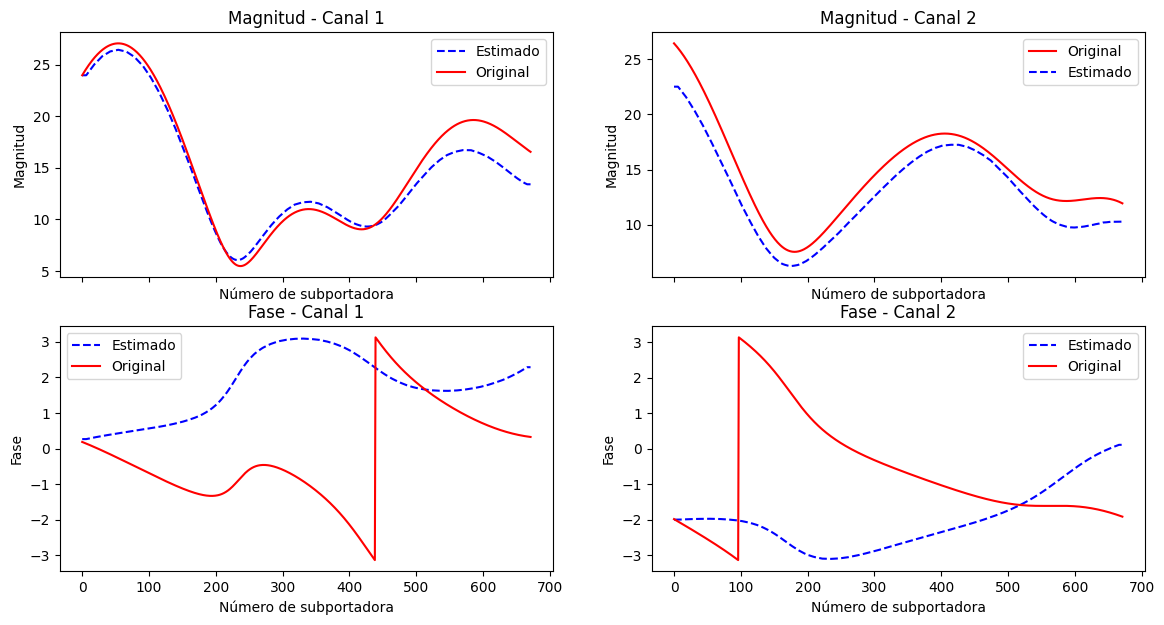

In [44]:
#Demodulacion OFDM
def demodulacionOFDM(ofdmRx, N, longitudCP):
    # Remover el CP (Prefijo Cíclico) de los símbolos OFDM recibidos
    ofdmSinPrefijo = ofdmRx[longitudCP:(N + longitudCP)]
    
    # Realizar la Transformada Rápida de Fourier (FFT) sobre los símbolos OFDM sin CP
    # fftshift se utiliza para centrar la frecuencia 0 en el centro del espectro
    data = np.fft.fft(ofdmSinPrefijo, N)
    return data

def estimacion(SenalRx):
    Referencias = []
    for antenarx in range(AntenasRx):
        Referencias_rx = []
        demod = demodulacionOFDM(SenalRx[antenarx][0:(N + longitudCP)], N, longitudCP)
        for l in range(len(demod)):
            if l%12 == 6:
                if l <= nSubportadoras:
                    Referencias_rx.append(demod[l])
        Referencias.append(Referencias_rx)
    h_estimado = [] 
    h_est = []
    for antenarx in range(AntenasRx):
        htx = []
        h_tx = []
        for antenatx in range(AntenasTx):
            hrx=[]
            h_rx=[]
            htx.append(hrx)
            h_tx.append(h_rx)
        h_estimado.append(htx)
        h_est.append(h_tx)
    for i in range(len(Referencias[0])):
        S = np.linalg.pinv(np.array([[Referencia],[Referencia]]))
        H = np.array([[Referencias[0][i]], [Referencias[1][i]]]) @ S
        for antenarx in range(AntenasRx):
            for antenatx in range(AntenasTx):
                h_estimado[antenarx][antenatx].append(H[antenarx][antenatx])
    indices_piloto = np.array([l for l in range(nSubportadoras) if l % 12 == 6])
    for antenarx in range(AntenasRx):
        for antenatx in range(AntenasTx):
            estimado_rx_pilotos = h_estimado[antenarx][antenatx].copy()
            real_interpolado = np.interp(np.arange(nSubportadoras),indices_piloto,  np.real(estimado_rx_pilotos))
            imag_interpolado = np.interp(np.arange(nSubportadoras),indices_piloto, np.imag(estimado_rx_pilotos))
            estimacion_canal = real_interpolado + 1j * imag_interpolado
            h_est[antenatx][antenarx] = estimacion_canal
    return h_est

if AntenasRx == 2:
    h_est = estimacion(Senal_Rxmp)
else:
    h_est = h

v = abs(h_est[0][1][0]/h[1][0][0])



fig, axs = plt.subplots(2, 2, figsize=(14, 7), sharex=True)
axs[0, 0].plot(abs(h_est[0][1]),'--b', label="Estimado")
axs[0, 0].plot(abs(h[1][0][0:nSubportadoras])*v,'r', label="Original")
axs[0, 0].set_title('Magnitud - Canal 1')
axs[0, 0].set_xlabel('Número de subportadora')
axs[0, 0].set_ylabel('Magnitud')
axs[0, 0].legend()

axs[1, 0].plot(np.angle(h_est[0][1]),'--b', label="Estimado")
axs[1, 0].plot(np.angle(h[1][0][0:nSubportadoras]),'r', label="Original")
axs[1, 0].set_title(f'Fase - Canal 1')
axs[1, 0].set_xlabel('Número de subportadora')
axs[1, 0].set_ylabel('Fase')
axs[1, 0].legend()


axs[0, 1].plot(abs(h[0][0][0:nSubportadoras])*v,'r', label="Original")
axs[0, 1].plot(abs(h_est[0][0]),'--b', label="Estimado")
axs[0, 1].set_title('Magnitud - Canal 2')
axs[0, 1].set_xlabel('Número de subportadora')
axs[0, 1].set_ylabel('Magnitud')
axs[0, 1].legend()

axs[1, 1].plot(np.angle(h_est[0][0]),'--b', label="Estimado")
axs[1, 1].plot(np.angle(h[0][0][0:nSubportadoras]),'r', label="Original")
axs[1, 1].set_title(f'Fase - Canal 2')
axs[1, 1].set_xlabel('Número de subportadora')
axs[1, 1].set_ylabel('Fase')
axs[1, 1].legend()


In [53]:
#Demodulacion OFDM

def demodulacionOFDM(ofdmRx, N, longitudCP):
    # Remover el CP (Prefijo Cíclico) de los símbolos OFDM recibidos
    ofdmSinPrefijo = ofdmRx[longitudCP:(N + longitudCP)]
    
    # Realizar la Transformada Rápida de Fourier (FFT) sobre los símbolos OFDM sin CP
    # fftshift se utiliza para centrar la frecuencia 0 en el centro del espectro
    data = np.fft.fft(ofdmSinPrefijo, N)
    return data

constelaciones = {
    'QPSK': qpsk,
    '16-QAM': qam16,
    '64-QAM': qam64
}
SenalRx = SenalRx[0]
def decision_vectorizada(modulado, matriz):
    # Calcular todas las distancias en una sola operación vectorizada
    distancias = np.abs(modulado[:, np.newaxis] - matriz)  # Broadcasting para calcular distancias
    indices = np.argmin(distancias, axis=1)  # Encuentra los índices de las distancias mínimas
    # Convertir los índices a binario de forma vectorizada
    bits = np.array([list(np.binary_repr(i, width=int(np.log2(len(matriz))))) for i in indices], dtype=int)
    return bits.flatten()  # Devolver como un solo vector plano

if Modulacion not in constelaciones:
    raise Exception('Modulation method must be QPSK, 16-QAM, or 64-QAM.')

# Selección de la constelación de acuerdo al tipo de modulación
constelacion = constelaciones[Modulacion]

for i in range(len(Senal_Rx)):
    W = np.linalg.pinv([[h_est[0][0][i],h_est[0][1][i]],[h_est[1][0][i],h_est[1][1][i]]])



rxDatos = []
datosSombrero = []
for antena in range(AntenasTx):
# Array para almacenar los símbolos de datos recuperados
    rxDatos1 = np.zeros(nSimbolos-nBloques, np.complex64)
    estimado_rx = []
    j = 0
    k = 0 
    x = 0
# Extraer el contenido de datos (después del final del L-LTF)
    L = len(SenalRx)
    Referencias_rx = []
# Demodular los símbolos OFDM en el contenido de datos
    for i in range(nSimbolosOFDM):
        rx_demod = demodulacionOFDM(SenalRx[k:(k + N + longitudCP)], N, longitudCP)
        if i == 0:
            for l in range(len(rx_demod)):
                if l%12 == 6:
                    if l <= nSubportadoras:
                        Referencias_rx.append(rx_demod[l])
                    x += 1
                else:
                    rxDatos1[l-x]=rx_demod[l]
            j = j + nSubportadoras - nBloques
            indices_piloto = np.array([l for l in range(nSubportadoras) if l % 12 == 6])
            indices_datos = np.array([l for l in range(nSubportadoras) if l % 12 != 6])

            # Estimación inicial del canal (pilotos)
            estimado_rx_pilotos = np.array(Referencias_rx) / Referencia

            # Interpolación lineal de la parte real e imaginaria
            real_interpolado = np.interp(np.arange(nSubportadoras),indices_piloto,  np.real(estimado_rx_pilotos))
            imag_interpolado = np.interp(np.arange(nSubportadoras),indices_piloto, np.imag(estimado_rx_pilotos))
            # Combinar parte real e imaginaria en un solo número complejo
            estimacion_canal = real_interpolado + 1j * imag_interpolado
        else:
            if i == (nSimbolosOFDM-1):
                rxDatos1[j:j + nSubportadoras] = rx_demod[0:(len(rxDatos1)-j)]/estimacion_canal[0:(len(rxDatos1)-j)]
            else:
                rxDatos1[j:j + nSubportadoras] = rx_demod[0:nSubportadoras]/estimacion_canal
        
        # Actualizar los índices para la siguiente iteración
            j = j + nSubportadoras
        k = k + N + longitudCP

    rxDatos.append(rxDatos1)

    #Demodulacion QPSK, 16-QAM, 64-QAM
    # Aplicar la función de decisión a todos los valores modulados de una vez
    dataSombrero = decision_vectorizada(rxDatos1, constelacion)
    datosSombrero.append(dataSombrero)
    if antena == AntenasTx-1:
        pass

    #Remodulación de los datos
    re_modulado = generarSimbolos(dataSombrero,Modulacion)
    for i in range(6,nSubportadoras,12):
        re_modulado = np.insert(re_modulado, i, Referencia)

    re_datosOFDM = np.zeros(nSimbolosOFDM * N, np.complex64)
    j = 0  # Índice para los datos de entrada
    k = 0  # Índice para los datos OFDM
    for i in range(nSimbolosOFDM):
        scArray = np.zeros(N, np.complex64)
        if i == (nSimbolosOFDM-1):
            longitud=len(re_modulado[j:j+nSubportadoras])
            if longitud < nSubportadoras:
                scArray[0:nSubportadoras] = np.concatenate((re_modulado[j:j+nSubportadoras],np.zeros(nSubportadoras-longitud)))
            else:
                scArray[0:nSubportadoras] = re_modulado[j:j+nSubportadoras]
        else:
            scArray[0:nSubportadoras] = re_modulado[j:j+nSubportadoras]
        # Realizar la modulación IFFT
        re_datosOFDM[k:k + N] = np.fft.ifft(scArray, N)  # Aplicar IFFT para convertir los datos al dominio del tiempo
        # Incrementar los índices
        j = j + nSubportadoras  # Incrementar el índice para los datos de entrada
        k = k + N  # Incrementar el índice para los datos OFDM
    if antena == AntenasTx-1:
        Valor = 1
    else:
        Valor = Power**(AntenasTx-(antena+1))
    re_ofdmConCP = np.zeros(nSimbolosOFDM * (N + longitudCP), np.complex64)  # Inicializar un array para los datos OFDM con CP
    j = 0
    k = 0
    for i in range(nSimbolosOFDM):
        re_ofdmConCP[k:(k + N + longitudCP)] = anadirPrefijo(re_datosOFDM[j:j + N], N, longitudCP)
        j = j + N
        k = k + N + longitudCP
    SenalRx -= re_ofdmConCP*Valor


### Calculo BER

In [54]:
def calcular_BER(bits_reales, bits_recibidos):
    if len(bits_reales) != len(bits_recibidos):
        raise ValueError("Los vectores deben tener la misma longitud.")
    
    # Calcular el número de bits en error
    errores = np.sum(bits_reales != bits_recibidos)
    
    # Calcular la Tasa de Error de Bit (BER)
    ber = errores / len(bits_reales)
    return ber

for antena in range(AntenasTx):
    dataSombrero=datosSombrero[antena]
    comp= datos[antena]
    print(f"BER señal {antena+1}: {calcular_BER(comp, dataSombrero)}")


BER señal 1: 2.7166453147877014e-05
BER señal 2: 8.28100216569058e-05
BER señal 3: 0.0004929281433016105
BER señal 4: 0.3010952131756345


### Imagenes recibidas

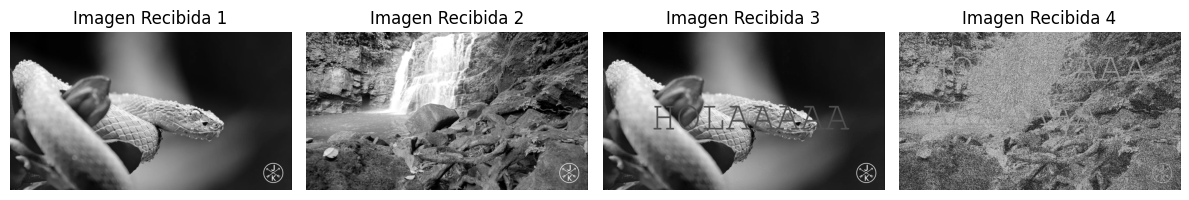

In [55]:
#Grafica recibida
fig, axes = plt.subplots(1, AntenasTx, figsize=(12, 6))
for antena in range(AntenasTx):
    datos_rx = datosSombrero[antena]
    bits_array = np.array(datos_rx, dtype=np.uint8)
    num_bytes = bits_array.size // 8  # Cantidad de bytes necesarios
    bytes_array = bits_array[:num_bytes * 8].reshape(-1, 8)
    pixels_array = np.packbits(bytes_array)

    # Reconstruir la imagen a partir de los píxeles
    # Primero, debemos saber la forma original de la imagen
    dimension_original = (768, 1366)  # Asegúrate de usar las dimensiones correctas
    imagen_recuperada = pixels_array.reshape(dimension_original)


# Mostrar la imagen recuperada


# Gráfica 1
    axes[antena].imshow(imagen_recuperada, cmap='gray')
    axes[antena].axis('off')
    axes[antena].set_title(f'Imagen Recibida {antena+1}')
plt.tight_layout()
plt.show()
